# Set up

Python librairies imports :

In [1]:
# File system management
import os
from pathlib import Path
import io

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image manipulation
from PIL import Image

# Dimension reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Pyspark
from pyspark.ml.feature import PCA as pyPCA
from pyspark.ml.functions import array_to_vector
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql import SparkSession

%matplotlib inline
sns.set_theme(palette="Set2")

Define work location :

In [2]:
# Current project path
PATH_PROJ = '/Users/victor/Documents/OPENCLASSROOMS/projet_8'

# Define images paths
PATH_DATA = PATH_PROJ + '/data/training'
PATH_RESULTS = PATH_PROJ + '/data/results'

# Change directory
os.chdir(PATH_PROJ)

Create the **Spark** session :

In [3]:
# Create sparkSession
spark = (SparkSession
         .builder
         .appName('oc_p8')
         .master('local')
         .config("spark.sql.parquet.writeLegacyFormat", 'true')
         .config("spark.driver.bindAddress","127.0.0.1")
         .getOrCreate())

# Create sparkContext
sc = spark.sparkContext

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/08 11:10:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data exploration

In [4]:
# Count images
img_count = len([f for f in Path(PATH_DATA).rglob('*.jpg') if f.is_file()])
print("Number of JPG files in " + PATH_DATA + " : " + str(img_count))

Number of JPG files in /Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training : 6231


In [5]:
# Create list of images
images_list = [(file_name, dir_path.split('/')[-1]) for (dir_path, _, file_names) in os.walk(PATH_DATA) \
               for file_name in file_names if file_name.endswith('.jpg')]

# Create dataframe
images_df = pd.DataFrame(images_list, columns=['image', 'label'])

# Add categories
images_df['category'] = images_df['label'].apply(lambda x: x.split('_')[0]) 
display(images_df.head())

,image,label,category
0,r0_190.jpg,cucumber_3,cucumber
1,r0_184.jpg,cucumber_3,cucumber
2,r0_52.jpg,cucumber_3,cucumber
3,r0_46.jpg,cucumber_3,cucumber
4,r0_8.jpg,cucumber_3,cucumber


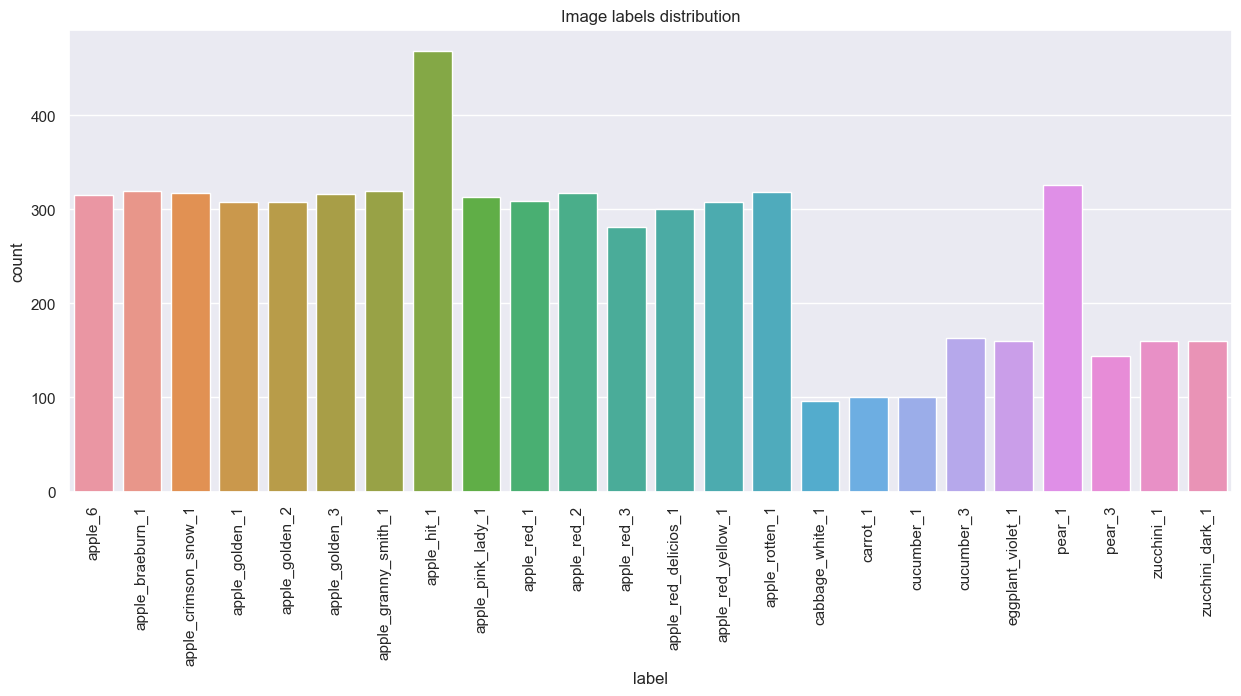

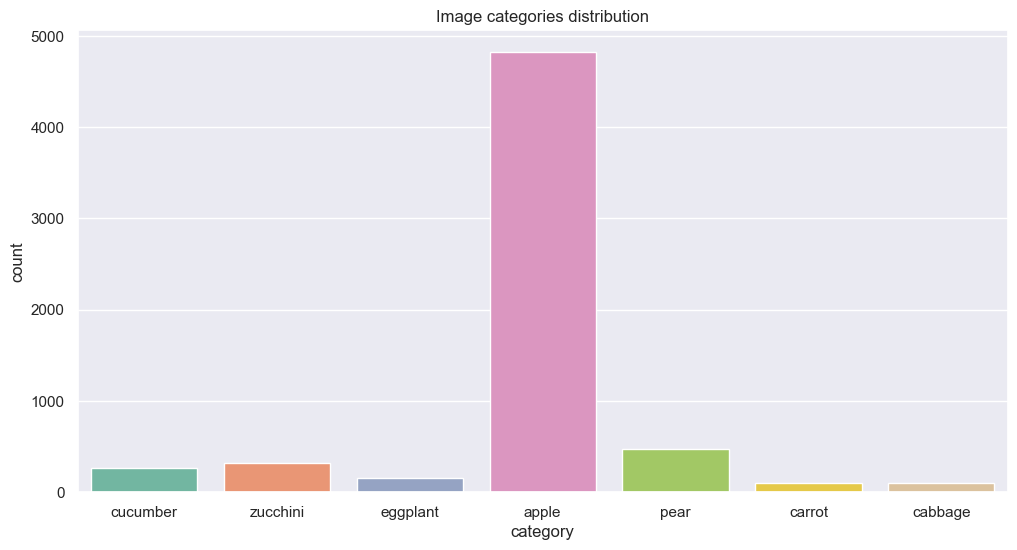

In [6]:
# Display image labels
plt.figure(figsize=(15, 6))
plt.title("Image labels distribution")
sns.countplot(x=images_df['label'].sort_values())
plt.xticks(rotation=90)
plt.show()

# Display image categories
plt.figure(figsize=(12, 6))
plt.title("Image categories distribution")
sns.countplot(x=images_df['category'])
# plt.xticks(rotation=90)
plt.show()

# Data processing

### Load images

In [7]:
# Load all images
images = spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg").option("recursiveFileLookup", "true").load(PATH_DATA)

In [8]:
# Display first images
images = images.withColumn('label', F.element_at(F.split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))
print("Number of images loaded : ", images.count())

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None


+-----------------------------------------------------------------------------------------+-----------+
|path                                                                                     |label      |
+-----------------------------------------------------------------------------------------+-----------+
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_116.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_114.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_108.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_118.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_120.jpg|apple_hit_1|
+-----------------------------------------------------------------------------------------+-----------+
only showing top 5 rows

None


Number of images loaded :  6231


### MobileNetV2 model

* Create a MobileNetV2 model with top layer removed and broadcasted pretrained weights.

In [9]:
# Load default model
mn_default = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Create model without top layer
mn_custom = Model(inputs=mn_default.input, outputs=mn_default.layers[-2].output)
display(mn_custom.summary())

# Create broadcast weights 
brodcast_weights = sc.broadcast(mn_custom.get_weights())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

None

In [10]:
def model_fn():
    """ Returns a MobileNetV2 model with top layer removed 
        and broadcasted pretrained weights.

    Returns:
        MobileNetV2 model
    """
    # Load default model
    mn = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    # Customize layers
    for layer in mn.layers:
        layer.trainable = False
    
    # Create model without top layer
    model = Model(inputs=mn.input, outputs=mn.layers[-2].output)

    # Broadcast weights to workers
    model.set_weights(brodcast_weights.value)

    return model

### Images features

* Preprocess and featurize the images with a MobileNetV2 model.

In [11]:
def preprocess(content):
    """Preprocesses raw image bytes.

    Args:
        content: PIL Image

    Returns:
        Numpy array
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

In [12]:
def featurize_series(model, content_series):
    """Featurize a pd.Series of raw images using the input model.

    Args:
        model: CNN model
        content_series: pd.Series of image data

    Returns:
        pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [13]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    """ This method is a Scalar Iterator pandas UDF wrapping our featurization function.
        The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    Args:
        content_series_iter: Iterator over batches of data, where each batch
                             is a pandas Series of image data.

    Yields:
        pd.Series of image features
    """
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Users/victor/miniconda3/envs/oc_p7/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [15]:
# Select 10% of dataset
images_sample = images.sample(fraction=0.1, seed=42)
display(images_sample.show(5))
display(images_sample.printSchema())
print("Number of images : ", images_sample.count())

+--------------------+-------------------+------+--------------------+-----------+
|                path|   modificationTime|length|             content|      label|
+--------------------+-------------------+------+--------------------+-----------+
|file:/Users/victo...|2021-09-12 19:23:44|122551|[FF D8 FF E0 00 1...|apple_hit_1|
|file:/Users/victo...|2021-09-12 19:23:44|121791|[FF D8 FF E0 00 1...|apple_hit_1|
|file:/Users/victo...|2021-09-12 19:23:44|121719|[FF D8 FF E0 00 1...|apple_hit_1|
|file:/Users/victo...|2021-09-12 19:23:46|117596|[FF D8 FF E0 00 1...|apple_hit_1|
|file:/Users/victo...|2021-09-12 19:23:46|116341|[FF D8 FF E0 00 1...|apple_hit_1|
+--------------------+-------------------+------+--------------------+-----------+
only showing top 5 rows



None

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)



None

Number of images :  627


In [16]:
# Create the image features
features_df = images_sample.repartition(20).select(F.col("path"), F.col("label"),
                                                   featurize_udf("content").alias('features'))

# Create the vectors
features_df = features_df.withColumn('features_vec', array_to_vector("features"))

display(features_df.show(5))
display(features_df.printSchema())

2023-03-08 11:11:03.723417: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


+--------------------+-----------+--------------------+--------------------+
|                path|      label|            features|        features_vec|
+--------------------+-----------+--------------------+--------------------+
|file:/Users/victo...|apple_hit_1|[0.3222898, 0.459...|[0.32228979468345...|
|file:/Users/victo...|apple_hit_1|[1.1753603, 0.059...|[1.17536032199859...|
|file:/Users/victo...| cucumber_3|[1.5150166, 0.201...|[1.51501655578613...|
|file:/Users/victo...|apple_red_3|[0.5331319, 0.003...|[0.53313189744949...|
|file:/Users/victo...|     pear_3|[0.6971466, 0.223...|[0.69714659452438...|
+--------------------+-----------+--------------------+--------------------+
only showing top 5 rows



None

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)



None

In [17]:
# Save results as parquet files
features_df.write.mode("overwrite").parquet(PATH_RESULTS)

2023-03-08 11:11:14.630944: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Dimension reduction

In [18]:
# Load results as a dataframe
res_df = pd.read_parquet(PATH_RESULTS, engine='pyarrow')

display(res_df.head())

,path,label,features,features_vec
0,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,apple_hit_1,"[0.3222898, 0.45961368, 0.06672078, 0.0, 0.012...","{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,apple_hit_1,"[1.1753603, 0.059681173, 0.76340306, 0.0, 0.02...","{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,cucumber_3,"[1.5150166, 0.20115007, 0.0851328, 0.000481274...","{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,apple_red_3,"[0.5331319, 0.0039223554, 0.0039826315, 0.0, 0...","{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,pear_3,"[0.6971466, 0.22352776, 0.23542322, 0.0, 0.0, ...","{'type': 1, 'size': None, 'indices': None, 'va..."


In [26]:
# Number features
features_n = res_df.loc[0, 'features'].shape[0]
print("The dimension of the features is", features_n)

The dimension of the features is 1280


### TSNE

,TSNE1,TSNE2,label
0,-10.263657,-16.953093,apple_hit_1
1,-18.363037,-4.576521,apple_hit_1
2,-38.171345,4.485195,cucumber_3
3,23.174194,-16.131527,apple_red_3
4,8.917556,-26.283802,pear_3


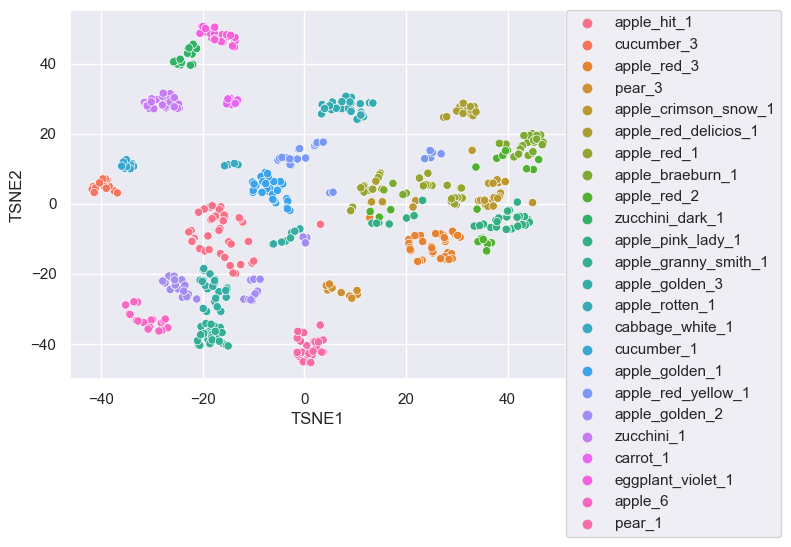

In [19]:
# Extract features
features = pd.DataFrame(res_df['features'].values.tolist(), index=res_df.index)

# Create t-sne dataframe
tsne_df = pd.DataFrame(TSNE(perplexity=20).fit_transform(features), columns=['TSNE1', 'TSNE2'])

# Add label
tsne_df['label'] = res_df['label']
display(tsne_df.head())

# Display scatterplot
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='label')
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
plt.show()

### Sklearn PCA

In [20]:
# Create PCA model
pca = PCA(n_components=100)

# Fit to data 
pca_data = pca.fit_transform(features_df)
pca_df = pd.DataFrame(pca_data, columns=['PCA'+str(i) for i in range(1, pca_data.shape[1]+1)])
display(pca_df.head())


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA91,PCA92,PCA93,PCA94,PCA95,PCA96,PCA97,PCA98,PCA99,PCA100
0,-5.406521,-6.325715,3.277808,1.652377,-1.239301,4.288008,1.269341,-4.382628,1.615665,0.599277,...,-0.214673,-0.113488,0.051794,0.431540,-0.270800,0.448810,-0.430451,0.241538,-0.655282,1.039243
1,-6.856058,-2.294338,-2.866751,-2.737641,1.549377,3.624317,1.759999,-3.727610,-2.141578,2.609696,...,0.590825,1.014602,0.525296,0.611893,0.045381,0.338985,-0.070546,-0.145154,0.942652,0.074940
2,-6.793586,6.898508,2.120467,-7.872387,2.867419,4.054073,-5.981027,4.276586,0.890353,-3.616574,...,0.226236,-0.118412,-0.467332,0.363326,0.075599,-0.078721,0.007520,-0.275398,-0.582178,-0.409921
3,4.206672,-1.385414,-1.109061,0.360157,3.286679,0.513481,1.780793,-0.205076,-3.028679,-2.126350,...,-0.095560,0.407361,-0.132949,0.736839,0.132610,0.140814,0.598994,0.345001,-0.532165,-0.538769
4,1.424643,-3.818304,2.080115,-2.695061,5.127030,1.514156,-0.695879,-4.071554,0.801479,0.268121,...,0.140314,-0.306297,-0.362759,0.291836,-0.408289,-0.260056,-0.090281,-0.108160,0.495968,-0.442234


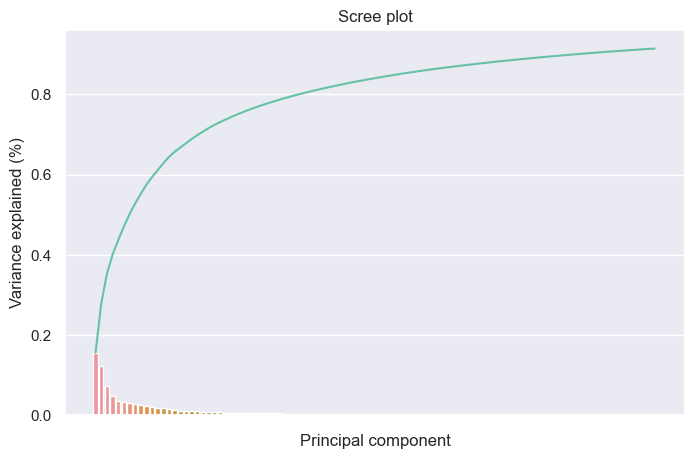

In [21]:
# Get explained variance ratio
pca_evr = list(pca.explained_variance_ratio_)
pca_evr_cumsum = np.cumsum(pca_evr)

# Display 
plt.figure(figsize=(8, 5))
plt.title("Scree plot")
sns.barplot(x=pca_df.columns, y=pca_evr)
sns.lineplot(x=pca_df.columns, y=pca_evr_cumsum)
plt.xlabel('Principal component')
plt.xticks('')
plt.ylabel('Variance explained (%)')
plt.show()

In [27]:
# Find thresholds
for th_val in [0.8, 0.85, 0.90, 0.95, 100]:
    th_idx = np.argmax(pca_evr_cumsum > th_val)
    if th_idx > 0:
        print('{:.0%} of the variance is explained by {} principal components ({:.4})' \
              .format(th_val, th_idx+1, pca_evr_cumsum[th_idx]))

# Show 100e component
print('{:.0%} of the variance is explained by {} principal components ({:.4})' \
              .format(pca_evr_cumsum[99], 100, pca_evr_cumsum[99]))


80% of the variance is explained by 37 principal components (0.8003)
85% of the variance is explained by 55 principal components (0.8512)
90% of the variance is explained by 86 principal components (0.9001)
91% of the variance is explained by 100 principal components (0.9145)


### Pyspark PCA

In [23]:
# Create pyspark PCA model
pca = pyPCA(k=34, inputCol='features_vec', outputCol='features_pca')

# Fit model
pca_model = pca.fit(features_df)

# Transform data
pca_data = pca_model.transform(features_df)

display(features_df.show(5))
display(features_df.printSchema())

AttributeError: 'DataFrame' object has no attribute '_jdf'